# 5: Writing your own reconstruction algorithm

PATATO is easy to extend to include your own reconstruction algorithms. You can extend the base `pat.ReconstructionAlgorithm` class, implementing your own version of the reconstruct function. Take a look at the documentation for this class for more details.

In [59]:
from typing import Sequence

import matplotlib.pyplot as plt
import numpy as np
import patato as pat
from patato.data import get_msot_time_series_example

# Add a loading bar
from tqdm.notebook import tqdm

class SlowBackprojection(pat.ReconstructionAlgorithm):
    """
    Slow example backprojection.
    """

    def reconstruct(self, time_series: np.ndarray,
                    fs: float,
                    geometry: np.ndarray, n_pixels: Sequence[int],
                    field_of_view: Sequence[float],
                    speed_of_sound: float,
                    **kwargs) -> np.ndarray:
        """

        Parameters
        ----------
        time_series: array_like
            Photoacoustic time series data in a numpy array. Shape: (..., n_detectors, n_time_samples)
        fs: float
            Time series sampling frequency (Hz).
        geometry: array_like
            The detector geometry. Shape: (n_detectors, 3)
        n_pixels: tuple of int
            Tuple of length 3, (nx, ny, nz)
        field_of_view: tuple of float
            Tuple of length 3, (lx, ly, lz) - the size of the reconstruction volume.
        speed_of_sound: float
            Speed of sound (m/s).
        kwargs
            Extra parameters (optional), useful for advanced algorithms (e.g. multi speed of sound etc.).

        Returns
        -------
        array_like
            The reconstructed image.

        """
        print("Running batch of delay and sum reconstruction code.")

        # Get useful parameters:
        dl = speed_of_sound / fs

        # Reshape frames so that we can loop through to reconstruct
        original_shape = time_series.shape[:-2]
        frames = int(np.product(original_shape))
        signal = time_series.reshape((frames,) + time_series.shape[-2:])

        xs, ys, zs = [np.linspace(-field_of_view[i]/2, field_of_view[i]/2, n_pixels[i]) if n_pixels[i] != 1 else np.array([0.]) for i in range(3)]
        Z, Y, X = np.meshgrid(zs, ys, xs, indexing='ij')
        
        # Note that the reconstructions are stored in memory in the order z, y, x (i.e. the x axis is the fastest changing in memory)
        output = np.zeros((frames,) + tuple(n_pixels)[::-1]) 
        
        for n_frame in tqdm(range(frames), desc="Looping through frames", position=0):
            for n_detector in tqdm(range(signal.shape[-2]), desc="Looping through detectors", position=1, leave=False):
                detx, dety, detz = geometry[n_detector]
                d = (np.sqrt((detx - X) ** 2 + (dety - Y) ** 2 + (detz - Z) ** 2) / dl).astype(np.int32)
                output[n_frame] += signal[n_frame, n_detector, d]
        return output.reshape(original_shape + tuple(n_pixels)[::-1])

    @staticmethod
    def get_algorithm_name() -> str:
        """

        Returns
        -------
        str
            Algorithm name.
        """
        return "Bad Backprojection"


Note that we haven't changed the pre processing code here. It still does the default behaviour of interpolating the signal and applying a Hilbert transform. This makes the reconstruction look a lot nicer than if we just pass in the raw time series data (although this does work). 

In [60]:
p = pat.MSOTPreProcessor() # make the images look nice :)
s = SlowBackprojection(n_pixels=(333,333,1), field_of_view=(0.025, 0.025, 0))

In [61]:
pa = get_msot_time_series_example()[0:1]
ts, settings, _ = p.run(pa.get_time_series(), pa)

We now have pre-processed data that can be reconstructed as usual. Note that PATATO automatically batches your data to prevent your computer running out of memory. The maximum batch size can be controlled by setting the environment variable `PAT_MAXIMUM_BATCH_SIZE`. By default this is 5, but it can definitely be higher on all but the most underpowered systems.

In [62]:
recon, _, _ = s.run(ts, pa, **settings)

Running batch of delay and sum reconstruction code.


Looping through frames:   0%|          | 0/5 [00:00<?, ?it/s]

Looping through detectors:   0%|          | 0/512 [00:00<?, ?it/s]

Looping through detectors:   0%|          | 0/512 [00:00<?, ?it/s]

Looping through detectors:   0%|          | 0/512 [00:00<?, ?it/s]

Looping through detectors:   0%|          | 0/512 [00:00<?, ?it/s]

Looping through detectors:   0%|          | 0/512 [00:00<?, ?it/s]

Running batch of delay and sum reconstruction code.


Looping through frames:   0%|          | 0/5 [00:00<?, ?it/s]

Looping through detectors:   0%|          | 0/512 [00:00<?, ?it/s]

Looping through detectors:   0%|          | 0/512 [00:00<?, ?it/s]

Looping through detectors:   0%|          | 0/512 [00:00<?, ?it/s]

Looping through detectors:   0%|          | 0/512 [00:00<?, ?it/s]

Looping through detectors:   0%|          | 0/512 [00:00<?, ?it/s]

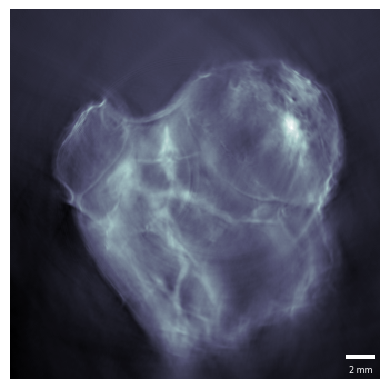

In [63]:
recon.imshow()
plt.show()